In [1]:
import sys
sys.path.insert(0, '../')

In [10]:
import pickle
import os
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from model.model import Actor, Critic, DRRAveStateRepresentation, PMF
from utils.history_buffer import HistoryBuffer

In [31]:
import matplotlib.pyplot as plt

In [5]:
saved_weights_dir = '../results/220629-143349/'
pmf_weight = '../trained/trained_pmf.pt'
test_data_path = '../dataset/test_data.npy'

In [6]:
test_data = np.load(test_data_path)
print(test_data.shape)

(25267, 4)


In [8]:
history_buffer_size = 5
embedding_feature_size = 100

In [12]:
# load params

state_rep_net = DRRAveStateRepresentation(n_items=history_buffer_size, item_features=embedding_feature_size, user_features=embedding_feature_size)
state_rep_net.load_state_dict(torch.load(os.path.join(saved_weights_dir, 'state_rep_net.weights')))

actor_net = Actor(in_features=3 * embedding_feature_size, out_features=embedding_feature_size)
actor_net.load_state_dict(torch.load(os.path.join(saved_weights_dir, 'actor_net.weights')))

<All keys matched successfully>

In [13]:
with open('../dataset/user_num_to_id.pkl', 'rb') as f:
    users = pickle.load(f)

with open('../dataset/item_num_to_id.pkl', 'rb') as f:
    items = pickle.load(f)

NUM_USERS, NUM_ITEMS = len(users), len(items)

In [15]:
reward_function = PMF(NUM_USERS, NUM_ITEMS, embedding_feature_size, is_sparse=False, no_cuda=True)

reward_function.load_state_dict(torch.load(pmf_weight))
for param in reward_function.parameters():
    param.requires_grad = False
    
user_embeddings, item_embeddings = reward_function.user_embeddings.weight.data, reward_function.item_embeddings.weight.data

In [17]:
user_embeddings.shape, item_embeddings.shape

(torch.Size([5380, 100]), torch.Size([15286, 100]))

In [28]:
def calculate_ndcg(rel, irel):
    dcg = 0
    idcg = 0
    for i, (r, ir) in enumerate(zip(rel, irel)):
        dcg += (r)/np.log2(i+2)
        idcg += (ir)/np.log2(i+2)
    return dcg, idcg

def discretize_reward_(x):
    x = x.item()
    if x<=1:
        return torch.tensor(1.0, dtype=torch.float64)
    elif x<=2:
        return torch.tensor(2.0, dtype=torch.float64)
    else:
        return torch.tensor(3.0, dtype=torch.float64)

In [21]:
user_idxs = np.unique(test_data[:, 0])
np.random.seed(121)
np.random.shuffle(user_idxs)

In [23]:
test_data = torch.from_numpy(test_data)

In [25]:
device = torch.device('cpu')

In [29]:
history_buffer = HistoryBuffer(history_buffer_size)
eps_eval = 0.1

precision = []
ndcg = []
mean_rewards = []
x = [*range(1, 11)]

for T in range(1, 11):
    mean_ndcg, mean_precision, steps = 0, 0, 0 
    
    r = 0
    
    for index, e in enumerate(user_idxs):
        
        # extract user reviews and positive user reviews for user id
        user_reviews = test_data[test_data[:, 0] == e]
        pos_user_reviews = user_reviews[user_reviews[:, 2] > 0]

        # history should be sufficient
        if pos_user_reviews.shape[0] < history_buffer_size:
            continue
            
        steps += 1    
        # sort user history by timestamp
        user_reviews = user_reviews[user_reviews[:, 3].sort(descending=True)[1]]
        pos_user_reviews = pos_user_reviews[pos_user_reviews[:, 3].sort(descending=True)[1]]

        # canditate items embedding for recommendation
        candidate_items = item_embeddings.detach().clone().to(device)

        # get user embedding
        user_emb = user_embeddings[e]
        
        history_buffer.clear()
        
        # fill up history buffer
        for i in range(history_buffer_size):
            emb = candidate_items[pos_user_reviews[i, 1]]
            history_buffer.push(emb.detach().clone())

        # get action
        with torch.no_grad():
            # use state rep net weights to get state (input args is user embedding and history buffer)
            state = state_rep_net(user_emb, torch.stack(history_buffer.to_list()))
            
            if np.random.uniform(0, 1) < eps_eval:
                action = torch.from_numpy(0.1 * np.random.rand(100)).float().to(device)
            else:
                action = actor_net(state.detach())
            

        # matmul for ranking scores
        ranking_scores = candidate_items @ action

        # get top T item indices
        values, indices = torch.topk(ranking_scores, T)
        
        # calculate reward for predictions
        rewards = [reward_function(torch.tensor(e).to(device) ,rec_item_index) for rec_item_index in indices]
        rewards = [discretize_reward_(reward).item() for reward in rewards]
        
        r += np.mean(rewards)

        correct_list = [1 if r ==3.0 else 0 for r in rewards]
        dcg, idcg = calculate_ndcg(correct_list, [1 for _ in range(len(rewards))])
        mean_ndcg += dcg/idcg
        
        correct_num = T-correct_list.count(0)
      
        mean_precision += correct_num/T
    
    precision.append(mean_precision/steps)
    ndcg.append(mean_ndcg/steps)
    mean_rewards.append(r/steps)
        
    print(f"T {T} mean precision {(mean_precision/steps):.2f}, mean_ndcg {(mean_ndcg/steps):.2f}, avg reward {(r/steps):.2f} total steps/users {steps}")

T 1 mean precision 0.14, mean_ndcg 0.14, avg reward 2.14 total steps/users 2545
T 2 mean precision 0.15, mean_ndcg 0.15, avg reward 2.15 total steps/users 2545
T 3 mean precision 0.14, mean_ndcg 0.14, avg reward 2.14 total steps/users 2545
T 4 mean precision 0.15, mean_ndcg 0.15, avg reward 2.14 total steps/users 2545
T 5 mean precision 0.14, mean_ndcg 0.14, avg reward 2.13 total steps/users 2545
T 6 mean precision 0.13, mean_ndcg 0.14, avg reward 2.13 total steps/users 2545
T 7 mean precision 0.13, mean_ndcg 0.14, avg reward 2.10 total steps/users 2545
T 8 mean precision 0.13, mean_ndcg 0.13, avg reward 2.09 total steps/users 2545
T 9 mean precision 0.13, mean_ndcg 0.13, avg reward 2.10 total steps/users 2545
T 10 mean precision 0.12, mean_ndcg 0.13, avg reward 2.06 total steps/users 2545


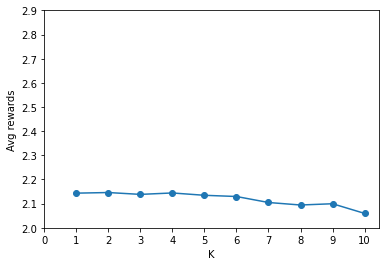

In [32]:
plt.plot([*range(1, 11)], mean_rewards, marker='o')
plt.yticks(np.arange(2, 3, step=0.1))
plt.xticks(np.arange(0, 11, step=1))
plt.xlabel("K")
plt.ylabel("Avg rewards")
plt.savefig("Average rewards vs K")
plt.show()